
# Exploring Overfitting in NLP

In [1]:
import csv
import random
import pickle
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
from scipy.stats import linregress

In [2]:
EMBEDDING_DIM = 100
MAXLEN = 16
TRUNCATING = 'post'
PADDING = 'post'
OOV_TOKEN = "<OOV>"
MAX_EXAMPLES = 160000
TRAINING_SPLIT = 0.9

## Explore the dataset

The dataset is provided in a csv file. 

Each row of this file contains the following values separated by commas:

- target: the polarity of the tweet (0 = negative, 4 = positive)

- ids: The id of the tweet

- date: the date of the tweet

- flag: The query. If there is no query, then this value is NO_QUERY.

- user: the user that tweeted

- text: the text of the tweet


Take a look at the first two examples:

In [3]:
SENTIMENT_CSV = "./data/training_cleaned.csv"

with open(SENTIMENT_CSV, 'r') as csvfile:
    print(f"First data point looks like this:\n\n{csvfile.readline()}")
    print(f"Second data point looks like this:\n\n{csvfile.readline()}")

First data point looks like this:

"0","1467810369","Mon Apr 06 22:19:45 PDT 2009","NO_QUERY","_TheSpecialOne_","@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D"

Second data point looks like this:

"0","1467810672","Mon Apr 06 22:19:49 PDT 2009","NO_QUERY","scotthamilton","is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!"



**Notice that this file does not have a header so you won't need to skip the first row when parsing the file.**

For the task at hand you will only need the information of the target and the text, which are the first and last element of each row. 

## Parsing the raw data

Now need to read the data from the csv file. To do so, complete the `parse_data_from_file` function.

A couple of things to note:

- You should NOT omit the first line as the file does not contain headers.
- There is no need to save the data points as numpy arrays, regular lists is fine.
- To read from csv files use `csv.reader` by passing the appropriate arguments.
- `csv.reader` returns an iterable that returns each row in every iteration. So the label can be accessed via `row[0]` and the text via `row[5]`.
- The labels are originally encoded as strings ('0' representing negative and '4' representing positive). **You need to change this so that the labels are integers and 0 is used for representing negative, while 1 should represent positive.**


In [28]:
def parse_data_from_file(filename):
    
    sentences = []
    labels = []
    corpus = []
    num_sentences = 0
    with open(filename, 'r') as csvfile:
        ### START CODE HERE
        reader = csv.reader(csvfile, delimiter=',')
        for row in reader:
            list_item = []
            list_item.append(row[5])
            this_label = row[0]
            if this_label == '0':
                list_item.append(0)
            else:
                list_item.append(1)
            num_sentences = num_sentences + 1
            corpus.append(list_item)
    random.shuffle(corpus)
    for x in range(MAX_EXAMPLES):
        sentences.append(corpus[x][0])
        labels.append(corpus[x][1])
    return sentences, labels

In [31]:
# Test the function
sentences, labels = parse_data_from_file(SENTIMENT_CSV)

print(f"dataset contains {len(sentences)} examples\n")

print(f"Text of second example should look like this:\n{sentences[1]}\n")
print(f"Text of fourth example should look like this:\n{sentences[3]}")

print(f"\nLabels of last 5 examples should look like this:\n{labels[-5:]}")

dataset contains 160000 examples

Text of second example should look like this:
i love pictures ! alot ! ahahhaa  i have to mannnyy

Text of fourth example should look like this:
@someone Kills me to see you online and not be able to say hello 

Labels of last 5 examples should look like this:
[1, 0, 1, 1, 0]


Noticed that this dataset contains a lot of examples. In order to keep a low execution time of this assignment you will be using only 10% of the original data. The next cell does this while also randomnizing the datapoints that will be used:

In [32]:
sentences_and_labels = list(zip(sentences, labels))

random.seed(42)
sentences_and_labels = random.sample(sentences_and_labels, MAX_EXAMPLES)

sentences, labels = zip(*sentences_and_labels)

print(f"There are {len(sentences)} sentences and {len(labels)} labels after random sampling\n")

There are 160000 sentences and 160000 labels after random sampling



## Training - Validation Split

In [33]:
def train_val_split(sentences, labels, training_split):
    
    
    train_size = int(len(sentences) * TRAINING_SPLIT)

    train_sentences = sentences[:train_size]
    train_labels = labels[:train_size]

    validation_sentences = sentences[train_size:]
    validation_labels = labels[train_size:]
        
    return train_sentences, validation_sentences, train_labels, validation_labels

In [34]:
# Test the function
train_sentences, val_sentences, train_labels, val_labels = train_val_split(sentences, labels, TRAINING_SPLIT)

print(f"There are {len(train_sentences)} sentences for training.\n")
print(f"There are {len(train_labels)} labels for training.\n")
print(f"There are {len(val_sentences)} sentences for validation.\n")
print(f"There are {len(val_labels)} labels for validation.")

There are 144000 sentences for training.

There are 144000 labels for training.

There are 16000 sentences for validation.

There are 16000 labels for validation.


## Tokenization - Sequences, truncating and padding

Now that have sets for training and validation it is time for you to begin the tokenization process.

In [41]:
def fit_tokenizer(train_sentences, NUM_WORDS,oov_token):
    
    tokenizer = Tokenizer(num_words = NUM_WORDS, oov_token=OOV_TOKEN)
    
    tokenizer.fit_on_texts(train_sentences)
    word_index = tokenizer.word_index

    train_sequences = tokenizer.texts_to_sequences(train_sentences)
    train_padded = pad_sequences(train_sequences, padding=PADDING, maxlen=MAXLEN)
        
    return tokenizer

In [42]:
tokenizer = fit_tokenizer(train_sentences,MAX_EXAMPLES, OOV_TOKEN)

word_index = tokenizer.word_index
VOCAB_SIZE = len(word_index)

print(f"Vocabulary contains {VOCAB_SIZE} words\n")
print("<OOV> token included in vocabulary" if "<OOV>" in word_index else "<OOV> token NOT included in vocabulary")
print(f"\nindex of word 'i' should be {word_index['i']}")

Vocabulary contains 128768 words

<OOV> token included in vocabulary

index of word 'i' should be 2


In [46]:
def seq_pad_and_trunc(sentences, tokenizer, padding, truncating, maxlen):
    
    sequences = tokenizer.texts_to_sequences(sentences)
    pad_trunc_sequences = pad_sequences(sequences, padding=PADDING, maxlen=MAXLEN)
        
    return pad_trunc_sequences

In [47]:
# Test the function
train_pad_trunc_seq = seq_pad_and_trunc(train_sentences, tokenizer, PADDING, TRUNCATING, MAXLEN)
val_pad_trunc_seq = seq_pad_and_trunc(val_sentences, tokenizer, PADDING, TRUNCATING, MAXLEN)

print(f"Padded and truncated training sequences have shape: {train_pad_trunc_seq.shape}\n")
print(f"Padded and truncated validation sequences have shape: {val_pad_trunc_seq.shape}")

Padded and truncated training sequences have shape: (144000, 16)

Padded and truncated validation sequences have shape: (16000, 16)


In [48]:
train_labels = np.array(train_labels)
val_labels = np.array(val_labels)

# Using pre-defined Embeddings

In particular will be using the 100 dimension version of [GloVe](https://nlp.stanford.edu/projects/glove/) from Stanford.

In [49]:
GLOVE_FILE = './data/glove.6B.100d.txt'

GLOVE_EMBEDDINGS = {}

with open(GLOVE_FILE) as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        GLOVE_EMBEDDINGS[word] = coefs

Now we have access to GloVe's pre-trained word vectors.

In [50]:
test_word = 'dog'

test_vector = GLOVE_EMBEDDINGS[test_word]

print(f"Vector representation of word {test_word} looks like this:\n\n{test_vector}")

Vector representation of word dog looks like this:

[ 0.30817    0.30938    0.52803   -0.92543   -0.73671    0.63475
  0.44197    0.10262   -0.09142   -0.56607   -0.5327     0.2013
  0.7704    -0.13983    0.13727    1.1128     0.89301   -0.17869
 -0.0019722  0.57289    0.59479    0.50428   -0.28991   -1.3491
  0.42756    1.2748    -1.1613    -0.41084    0.042804   0.54866
  0.18897    0.3759     0.58035    0.66975    0.81156    0.93864
 -0.51005   -0.070079   0.82819   -0.35346    0.21086   -0.24412
 -0.16554   -0.78358   -0.48482    0.38968   -0.86356   -0.016391
  0.31984   -0.49246   -0.069363   0.018869  -0.098286   1.3126
 -0.12116   -1.2399    -0.091429   0.35294    0.64645    0.089642
  0.70294    1.1244     0.38639    0.52084    0.98787    0.79952
 -0.34625    0.14095    0.80167    0.20987   -0.86007   -0.15308
  0.074523   0.40816    0.019208   0.51587   -0.34428   -0.24525
 -0.77984    0.27425    0.22418    0.20164    0.017431  -0.014697
 -1.0235    -0.39695   -0.0056188  0.3

In [51]:
print(f"Each word vector has shape: {test_vector.shape}")

Each word vector has shape: (100,)


## Represent the words in your vocabulary using the embeddings

A couple of things to notice:
- If a word in your vocabulary is not present in `GLOVE_EMBEDDINGS` the representation for that word is left as a column of zeros.
- `word_index` starts counting at 1, because of this you will need to add an extra column at the left-most side of the `EMBEDDINGS_MATRIX` array. This is the reason why you add 1 to `VOCAB_SIZE` in the cell below:

In [52]:
# Initialize an empty numpy array with the appropriate size
EMBEDDINGS_MATRIX = np.zeros((VOCAB_SIZE+1, EMBEDDING_DIM))

# Iterate all of the words in the vocabulary and if the vector representation for 
# each word exists within GloVe's representations, save it in the EMBEDDINGS_MATRIX array
for word, i in word_index.items():
    embedding_vector = GLOVE_EMBEDDINGS.get(word)
    if embedding_vector is not None:
        EMBEDDINGS_MATRIX[i] = embedding_vector

Now you have the pre-trained embeddings ready to use!

## Define a model that does not overfit

A couple of things to note / hints:

- The first layer is provided so you can see how the Embedding layer is configured when using pre-trained embeddings


- You can try different combinations of layers covered in previous ungraded labs such as:
    - `Conv1D`
    - `Dropout`
    - `GlobalMaxPooling1D`    
    - `MaxPooling1D`    
    - `LSTM`    
    - `Bidirectional(LSTM)`


- The last two layers should be `Dense` layers.


- There multiple ways of solving this problem. So try an architecture that you think will not overfit.


- Try simpler architectures first to avoid long training times. Architectures that are able to solve this problem usually have around 3-4 layers (excluding the last two `Dense` ones)


- Include at least one `Dropout` layer to mitigate overfitting.

In [54]:
def create_model(vocab_size, embedding_dim, maxlen, embeddings_matrix):
    
    ### START CODE HERE
    
    model = tf.keras.Sequential([ 
        tf.keras.layers.Embedding(vocab_size+1, embedding_dim, input_length=maxlen, weights=[embeddings_matrix], trainable=False),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Conv1D(64, 5, activation='relu'),
        tf.keras.layers.MaxPooling1D(pool_size=4),
        tf.keras.layers.LSTM(64),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy']) 

    return model

In [55]:
model = create_model(VOCAB_SIZE, EMBEDDING_DIM, MAXLEN, EMBEDDINGS_MATRIX)

history = model.fit(train_pad_trunc_seq, train_labels, epochs=20, validation_data=(val_pad_trunc_seq, val_labels))

Epoch 1/20
4500/4500 [==============================] - 37s 8ms/step - loss: 0.5623 - accuracy: 0.7054 - val_loss: 0.5208 - val_accuracy: 0.7349
Epoch 2/20
4500/4500 [==============================] - 36s 8ms/step - loss: 0.5213 - accuracy: 0.7373 - val_loss: 0.5000 - val_accuracy: 0.7485
Epoch 3/20
4500/4500 [==============================] - 36s 8ms/step - loss: 0.5049 - accuracy: 0.7486 - val_loss: 0.5014 - val_accuracy: 0.7472
Epoch 4/20
4500/4500 [==============================] - 36s 8ms/step - loss: 0.4919 - accuracy: 0.7573 - val_loss: 0.4917 - val_accuracy: 0.7599
Epoch 5/20
4500/4500 [==============================] - 37s 8ms/step - loss: 0.4828 - accuracy: 0.7633 - val_loss: 0.4934 - val_accuracy: 0.7576
Epoch 6/20
4500/4500 [==============================] - 37s 8ms/step - loss: 0.4770 - accuracy: 0.7674 - val_loss: 0.4890 - val_accuracy: 0.7588
Epoch 7/20
4500/4500 [==============================] - 36s 8ms/step - loss: 0.4699 - accuracy: 0.7713 - val_loss: 0.4881 - val_ac

Run the following cell to check the loss curves:

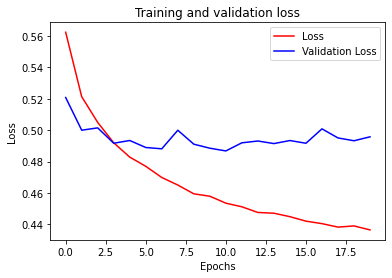

In [56]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = [*range(20)]

plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])
plt.show()

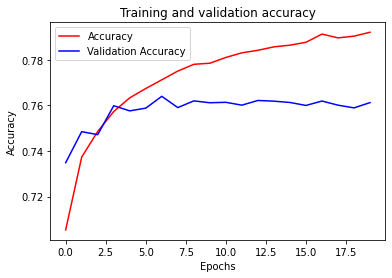

In [57]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Accuracy", "Validation Accuracy"])
plt.show()

A more rigorous way of setting the passing threshold of this assignment is to use the slope of your `val_loss` curve.

In [58]:
# Test the slope of your val_loss curve
slope, *_ = linregress(epochs, val_loss)
print(f"The slope of your validation loss curve is {slope:.5f}")

The slope of your validation loss curve is -0.00042


**If the model generated a validation loss curve that meets the criteria above, run the following cell and then submit your assignment for grading. Otherwise, try with a different architecture.**

In [59]:
with open('history.pkl', 'wb') as f:
    pickle.dump(history.history, f)